# Higgs boson mass 

One of the most sensitive channels for measuring the mass of the Higgs boson ($H$) at the LHC is the diphoton ($H\rightarrow \gamma\gamma$) decay channel. This is because the signal creates a very clear peak on top of a smooth background when looking at the invariant mass of the two photons in each event - $m_{\gamma\gamma}$, 

$$
m_{\gamma\gamma} = 2E_{1}E_{2}(1-cos\phi)
$$

where $E_{1}$ and $E_{2}$ are the energies of the two photons and $\phi$ is the angle between their momenta. 

The image below shows an event recorded at the CMS detector that we think is a good candidate for a $H\rightarrow\gamma\gamma$ decay.

![HiggsBoson](diphotonevent.png)

In [1]:
%matplotlib notebook

import numpy,pandas
from scipy.stats import norm
from scipy.stats import poisson

import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (7, 6)

I've taken some (fake) data from the CMS publication JHEP 07 (2021) 027, which we can use to build a likelihood function. The data are just the values of $m_{\gamma\gamma}$ in each selected event for the analysis. 

In [2]:
data = pandas.read_csv("diphoton_mass.txt")
data.head()

,mass
0,169.472824
1,142.262177
2,107.682999
3,117.114548
4,152.154053


In [3]:
masses = data['mass'].to_numpy()
print(len(masses))


90126


<IPython.core.display.Javascript object>


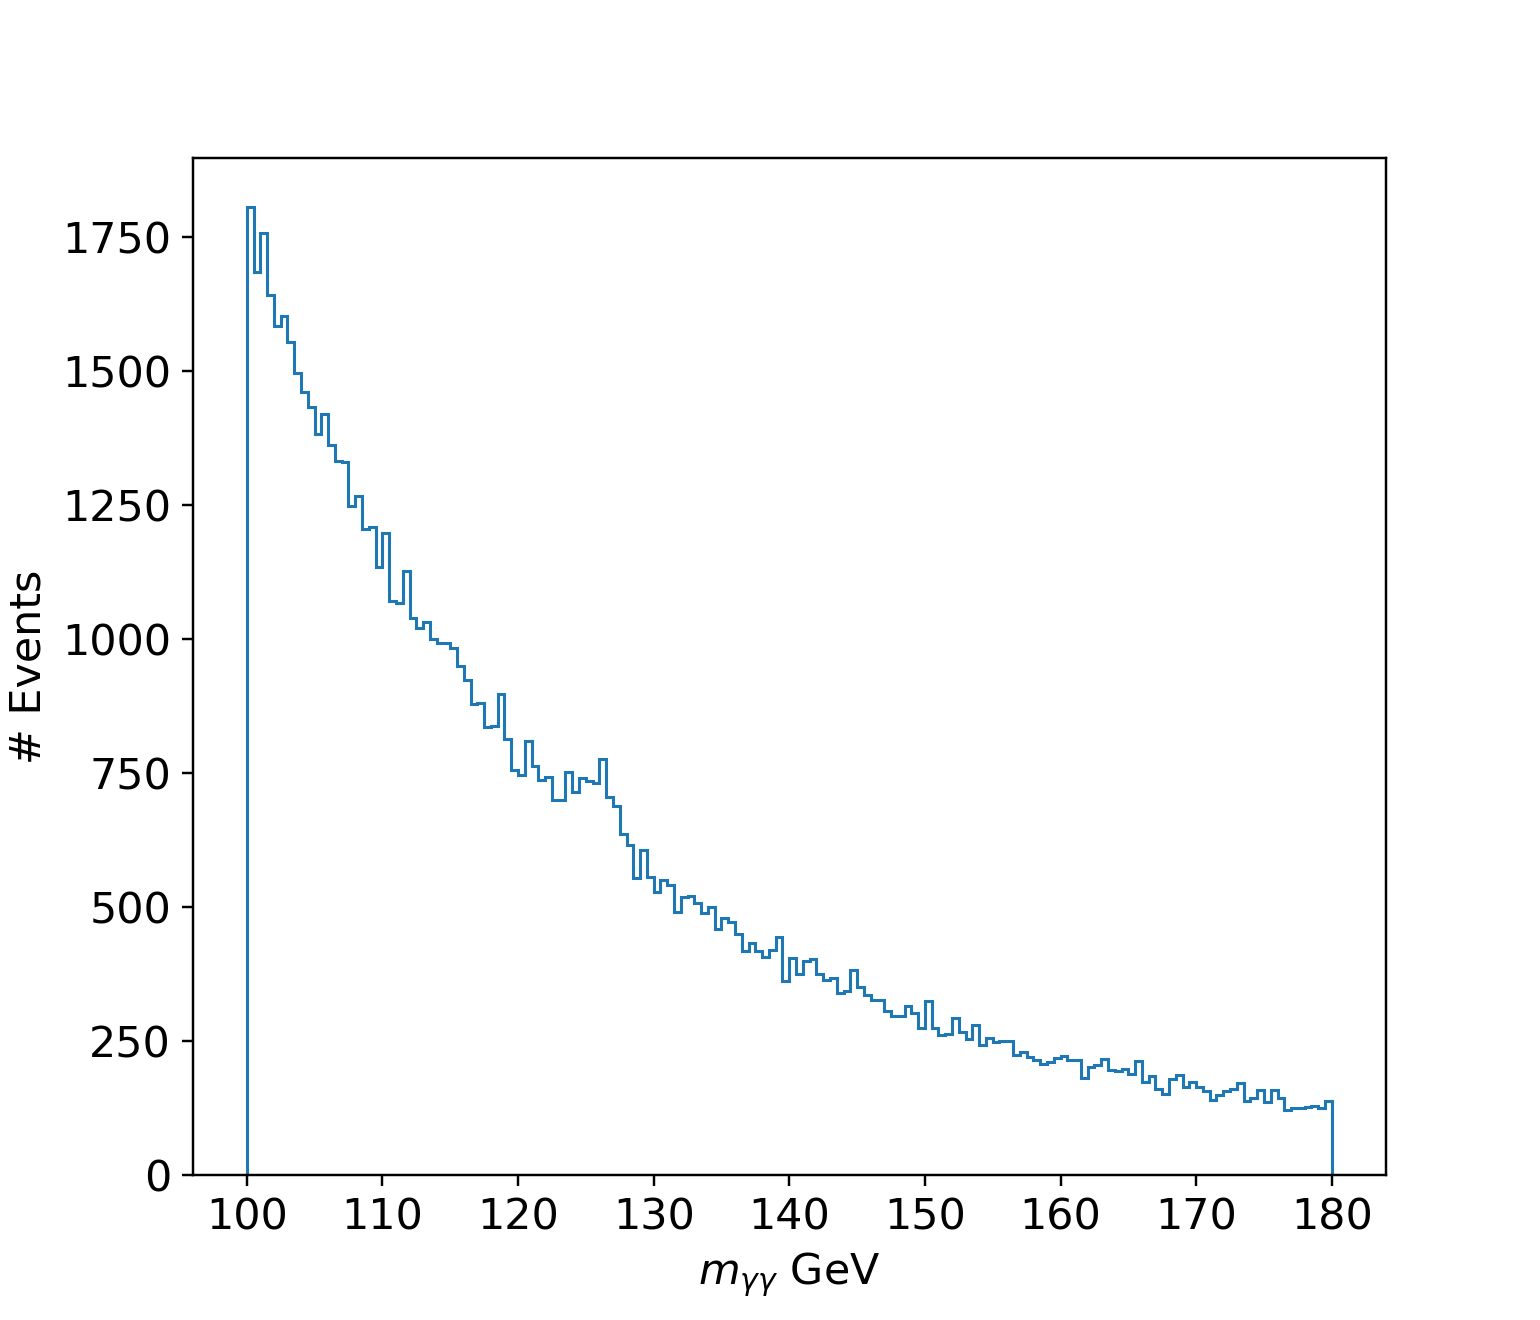

In [4]:
hist = plt.hist(masses,bins=160,range=(100,180),histtype='step',density=False)
plt.xlabel("$m_{\gamma\gamma}$ GeV")
plt.ylabel("# Events")
plt.show()

 We want to construct probability density functions for the signal (the $H\rightarrow\gamma\gamma$ decays) and background processes. From this and the data, we will construct a likelihood function to obtain an estimate of the Higgs boson mass. 
 
We can assume that the signal component $p_{S}(m_{\gamma\gamma})$ is a Gaussian with  $\mu$ parameter $m_{H}$ and a $\sigma$ parameter fixed to 1.64 (which is roughly the expected invariant mass resolution in these events at CMS). 

$$
	p_{S}(m_{\gamma\gamma}) = \frac{1}{1.64\sqrt{2\pi}} e^{-\dfrac{1}{2}\dfrac{(m_{\gamma\gamma}-m_{H})^{2}}{1.64^{2}}}
$$
	
The background component $p_{B}(m_{\gamma\gamma})$ should be a power law function. 
	
$$
	p_{B}(m_{\gamma\gamma}) = K  m_{\gamma\gamma}^{-\alpha}
$$
Where $K$ is the normalising factor given by $1 = \int_{100}^{180}K	m_{\gamma\gamma}^{-\alpha} dm$ --  i.e $K=\frac{(1-\alpha)}{180^{(1-\alpha)} -100^{(1-\alpha)} }$
	
We can write the total probability density function as, 
	
$$
	p(m_{\gamma\gamma}) = f_{S}p_{S} + (1-f_{S})p_{B}
$$

In [5]:
sigma = 1.64

# calculate K, the power law normalisation
def norm_B(alpha):
    r = 180**(-1.*alpha+1)-100**(-1.*alpha+1)
    c = (-1.*alpha+1) * (1./r)
    return c 

@numpy.vectorize
def prob(x,MH,fs,alpha):
    pB = (1-fs)*norm_B(alpha)*(x**(-1.*alpha))
    pS = fs*norm.pdf(x,MH,sigma)
    return pB+pS

@numpy.vectorize
def prob_fast(x,g,fs,alpha):
    pB = (1-fs)*norm_B(alpha)*(x**(-1.*alpha))
    pS = fs*g
    return pB+pS

# use the vectorised pdf to make things much faster
def gausses(data,MH,sigma):
    return norm.pdf(data,MH,sigma)

Now we can construct the negative log-likelihood function which is given by, 

$$
q = -\ln(L) = -\sum_{i=1}^{N}\ln p(m^{i}_{\gamma\gamma})
$$

In [6]:
def neg_log_likelihood(pars,data): # == q 
    MH=pars[0]
    fs=pars[1]
    alpha=pars[2]

    N  = len(data)
    gs = gausses(data,MH,sigma)
    log_l = sum(numpy.log(prob_fast(data,gs,fs,alpha)))

    return -1*log_l

def model(x,MH,fs,alpha):
    return prob(x,MH,fs,alpha)

There are 3 parameters of the model that we need to estimate $f_{S},m_{H}$ and $\alpha$. Varying these parameters,  we can see that the value of q changes dramatically depending on the values. Those which yield densities similar to the data give smaller valyes of q. 

In [12]:
tests=100
xr = numpy.linspace(100,180,160)

<IPython.core.display.Javascript object>


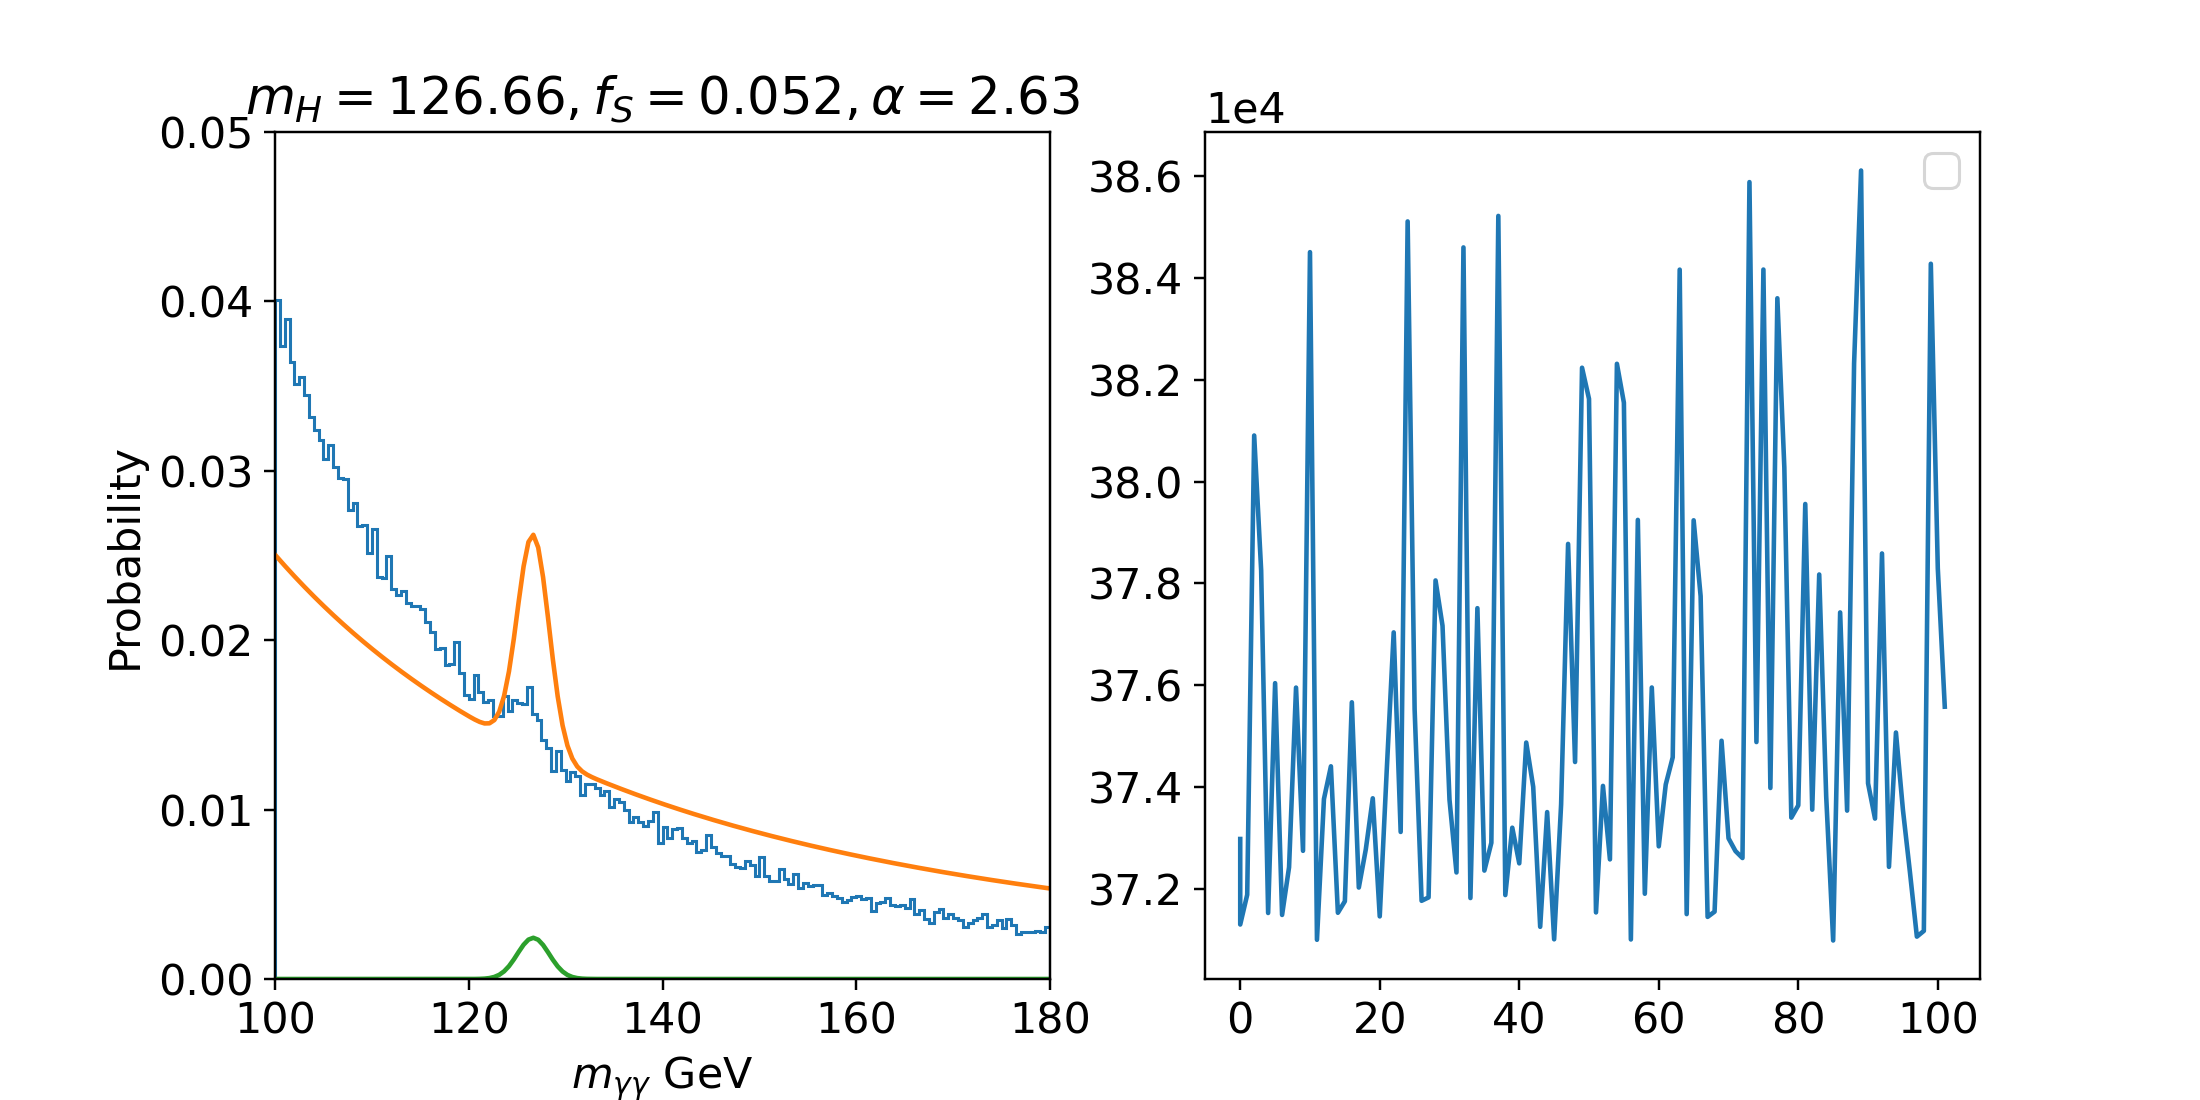

In [40]:
curr=0
q_vals    = []
curr_vals = []
def update(curr):
    if curr>tests:
        anim.event_source.stop()
    ax1.cla()
    ax2.cla()
    
    # pick random points in the 3D space 
    r_mh = numpy.random.uniform(123.,128.)
    r_fs = numpy.random.uniform(0.,0.1)
    r_alpha = numpy.random.uniform(1.,6.)
    
    ax1.hist(masses,bins=160,range=(100,180),histtype='step',density=True)
    
    ax1.plot(xr,model(xr,r_mh,r_fs,r_alpha),label='signal+background')
    ax1.plot(xr,0.01*norm.pdf(xr,r_mh,sigma),label='signal')

    ax1.axis([100,180,0,0.05])
    ax1.set_xlabel("$m_{\gamma\gamma}$ GeV")
    ax1.set_ylabel("Probability")
    ax1.set_title("$m_{H}=%.2f,f_{S}=%.3f,\\alpha=%.2f$"%(r_mh,r_fs,r_alpha))
    
    q = neg_log_likelihood([r_mh,r_fs,r_alpha],masses)
    curr_vals.append(curr)
    q_vals.append(q)
    
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
    ax2.plot(curr_vals,q_vals)
    ax2.legend()
    curr+=1

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

#fig =  plt.figure()
anim = animation.FuncAnimation(fig,update,interval=500)
plt.show()

In [9]:
# Here i'm using iminuit minimizer 
import iminuit.minimize as minimize

N = len(masses)

bounds = [[123,128],[0,1],[1,6.]]
res = minimize(neg_log_likelihood,[125.5,0.01,4.],args=[masses],bounds=bounds)
print(res)
print("Maximum likelihood estimates -> ", res.x)

bestfit_mh = res.x[0]

      fun: 370951.08769888856
 hess_inv: [[ 5.23535340e-02 -1.43731219e-05  1.34526374e-04]
 [-1.43731219e-05  1.11211277e-06  1.29949513e-06]
 [ 1.34526374e-04  1.29949513e-06  4.76304440e-04]]
  message: 'Optimization terminated successfully.'
   minuit: <FMin algorithm='Migrad' edm=1.314238796855491e-05 edm_goal=0.0001 errordef=0.5 fval=370951.08769888856 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=59 ngrad=0 reduced_chi2=nan>
(Param(number=0, name='x0', value=125.95593210943281, error=0.22847866080247314, merror=None, is_const=False, is_fixed=False, lower_limit=123.0, upper_limit=128.0), Param(number=1, name='x1', value=0.009259999513905492, error=0.0010545462672562345, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1.0), Param(number=2, name='x2', value=4.487754

Make a plot of the probability density with the parameters set to the maximum likelihood estimates, and the compare to the data. 

<IPython.core.display.Javascript object>


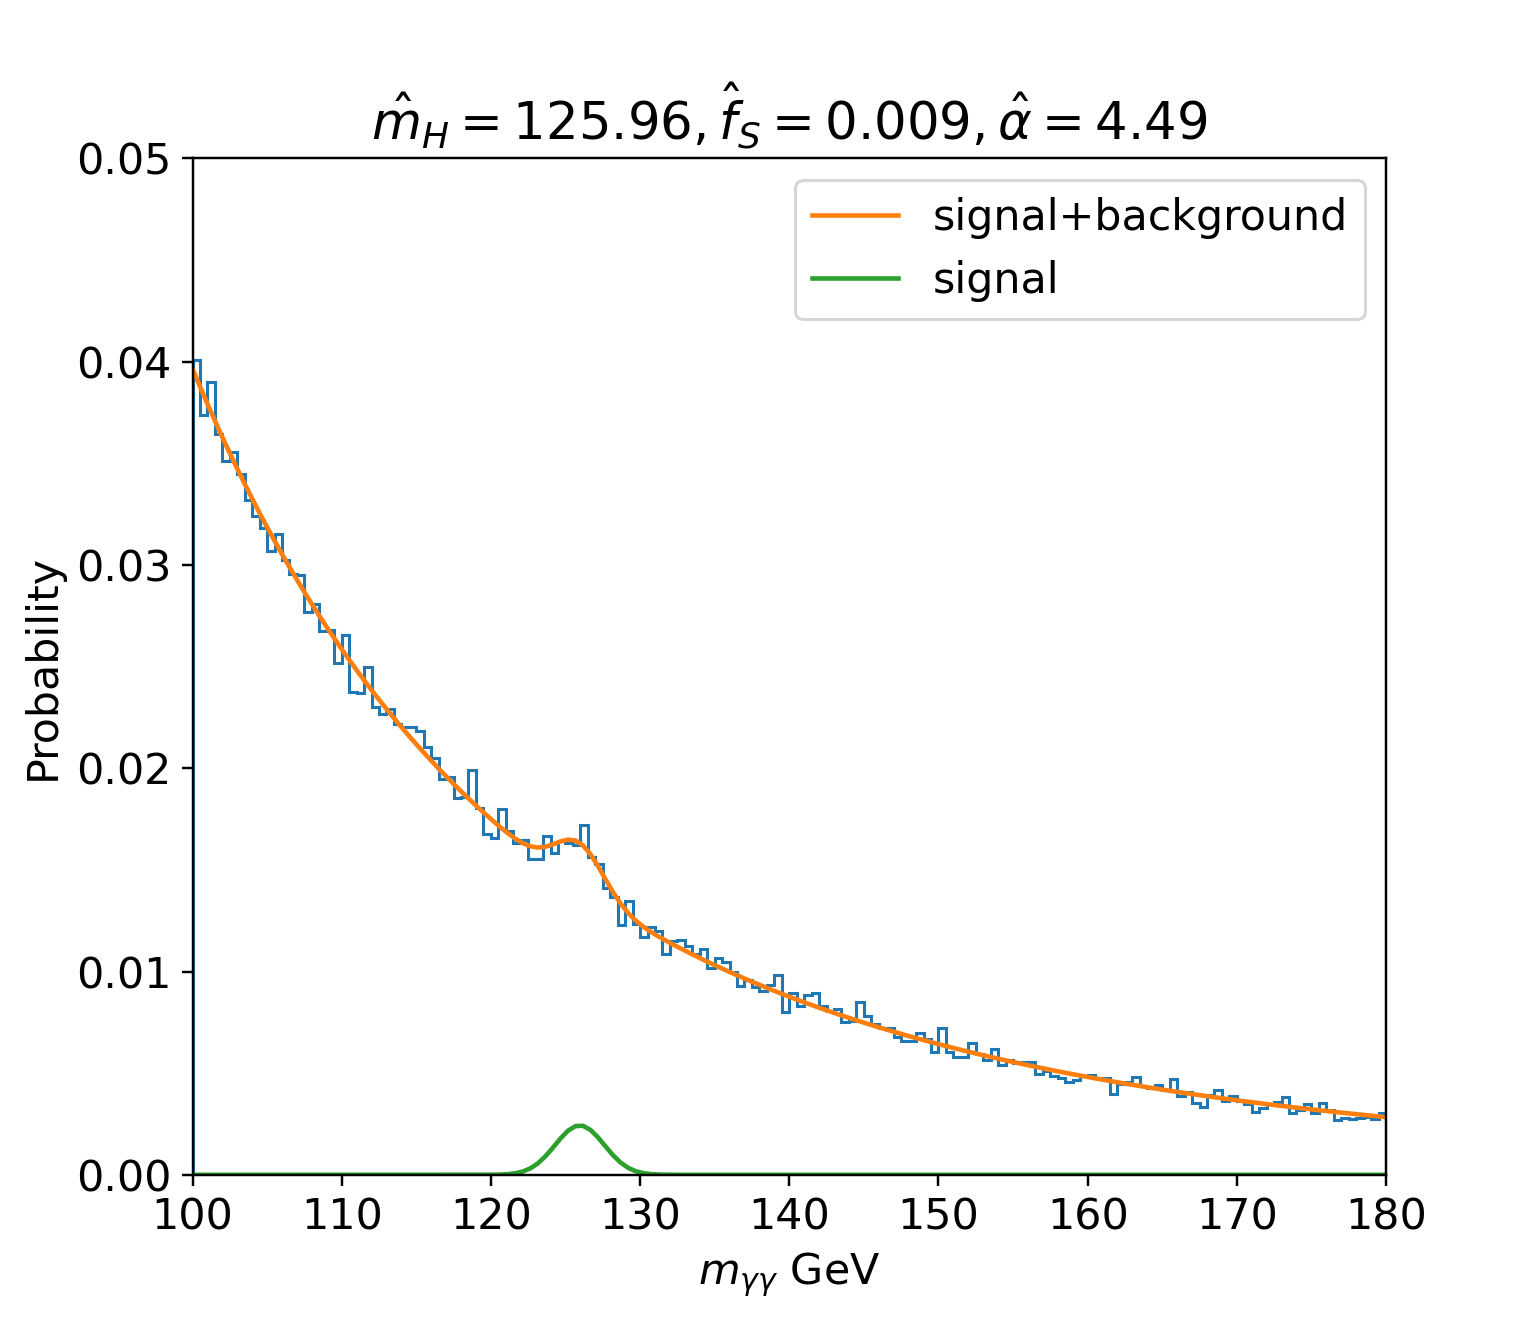

In [42]:
fig =  plt.figure()
plt.cla()
plt.hist(masses,bins=160,range=(100,180),histtype='step',density=True)
plt.plot(xr,model(xr,res.x[0],res.x[1],res.x[2]),label='signal+background')
plt.plot(xr,0.01*norm.pdf(xr,res.x[0],sigma),label='signal')
plt.axis([100,180,0,0.05])
plt.xlabel("$m_{\gamma\gamma}$ GeV")
plt.ylabel("Probability")
plt.title("$\hat{m}_{H}=%.2f,\hat{f}_{S}=%.3f,\hat{\\alpha}=%.2f$"%(res.x[0],res.x[1],res.x[2]))
plt.legend()
plt.show()